# Latitude by Latitude Quantile Plots
This notebook produces plots to illustrate how the high quantiles for near surface air temperature vary with longwave optical depth ($CO_2$ concentration proxy).

It combines all simulations run in each plot.

It is similar to `quantile_notebook2_summer.ipynb` except that it combines variables and theories for each latitude independently before area averaging them in the final plots.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, moist_static_energy
from isca_tools.utils.constants import L_v, c_p
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
from scipy.stats import percentileofscore
import numpy_indexed
import warnings
from isca_tools.papers.byrne_2021 import get_delta_temp_quant_theory, get_px, get_quant_ind

2023-05-09 17:18:15,737 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset
var_keep = ['temp', 'sphum', 'height']
exp_dir = 'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
tau_lw = np.asarray(tau_lw)
p_surface = float(ds[0].pfull) * 100

100%|██████████| 9/9 [00:12<00:00,  1.39s/it]


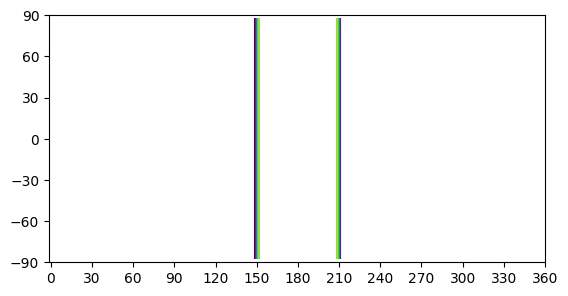

In [3]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Near Surface Temperature Quantile
Plot quantile of near surface air temperature vs global average near surface air temperature for a given latitude band.

Near surface air temperature is the temperature at the lowest pressure level.

Here, we compute the quantile at each latitude coordinate across all longitudes and time and then average over these.

We average over all times after 2 years because, from the spin up plot above, after 2 years, the simulation has converged into a regular pattern, with a net TOA flux centered on 0.

In [110]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2

lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]

# Chose whether to only consider summer days or consider all days
# season = 'summer'
season = 'all'

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# region = 'Global'
# lat_min = 0
# lat_max = 90

temp_av = {'ocean': np.zeros(n_exp), 'land': np.zeros(n_exp)}
ds_all = {'ocean': [], 'land': []}    # near surface temperature for each optical depth value
with tqdm(total=n_exp * 2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) < lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
        if season == 'summer':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_use = ds_use.load()
        for surf in ['land', 'ocean']:
            ds_all[surf] += [ds_use.isel(lon_time=np.where(np.isin(ds_use.lon, np.unique(lon[surf])))[0])]
            pbar.update(1)

100%|██████████| 18/18 [00:16<00:00,  1.09it/s]


In [111]:
# Compute quantile near surface temperature across longitude, latitude and time dimension
# This takes about 3 minutes to run for tropics, 15 minutes for global
quant_all = np.arange(100)
n_quant_all = len(quant_all)
n_lat = len(ds_all['ocean'][0].lat)
lat_weights = np.cos(np.deg2rad(ds_all['ocean'][0].lat))     # latitude area weighting is just the cosine

temp_mean = {surf: np.asarray([ds_all[surf][i].temp.mean(dim='lon_time') for i in range(n_exp)]) for surf in ['ocean', 'land']}
sphum_mean = {surf: np.asarray([ds_all[surf][i].sphum.mean(dim='lon_time') for i in range(n_exp)]) for surf in ['ocean', 'land']}
temp_quant_p = {'ocean': np.zeros((n_exp, n_lat, n_quant_all)), 'land': np.zeros((n_exp, n_lat, n_quant_all))}
temp_quant_x = {'ocean': np.zeros((n_exp, n_lat, n_quant_all)), 'land': np.zeros((n_exp, n_lat, n_quant_all))}
sphum_quant_x = {'ocean': np.zeros((n_exp, n_lat, n_quant_all)), 'land': np.zeros((n_exp, n_lat, n_quant_all))}
sphum_quant_p = {'ocean': np.zeros((n_exp, n_lat, n_quant_all)), 'land': np.zeros((n_exp, n_lat, n_quant_all))}
mse_quant_x = {'ocean': np.zeros((n_exp, n_lat, n_quant_all)), 'land': np.zeros((n_exp, n_lat, n_quant_all))}
with tqdm(total=n_exp * n_lat * n_quant_all * 2, position=0, leave=True) as pbar:
    for surf in ['ocean', 'land']:
        for i in range(n_exp):
            if surf == 'ocean':
                # only compute p version of quantile for ocean, as needed for theory
                temp_quant_p[surf][i] = ds_all[surf][i].temp.quantile(quant_all/100, dim='lon_time').transpose()
                sphum_quant_p[surf][i] = ds_all[surf][i].sphum.quantile(quant_all/100, dim='lon_time').transpose()
            for j in range(n_quant_all):
                for k in range(n_lat):
                    use_ind = get_quant_ind(ds_all[surf][i].temp[k], quant_all[j])
                    temp_quant_x[surf][i, k, j] = ds_all[surf][i].temp[k, use_ind].mean()
                    sphum_quant_x[surf][i, k, j] = ds_all[surf][i].sphum[k, use_ind].mean()
                    mse_quant_x[surf][i, k, j] = moist_static_energy(ds_all[surf][i].temp[k, use_ind],
                                                                     ds_all[surf][i].sphum[k, use_ind],
                                                                     ds_all[surf][i].height[k, use_ind]).mean()
                    pbar.update(1)

100%|██████████| 115200/115200 [21:27<00:00, 89.50it/s] 


## Figure 4 of O'Gorman & Schneider 2009
### Tropics
In the plot below, all the gradients are below 1, indicating that the hottest days warm less quickly than the average day. If we look at the largest $\kappa$ values, it is also clear that the gradient here is a lot larger than the gradient at lower $\kappa$ and thus causes the gradients to be larger than maybe they appear by eye.

In [112]:
def get_gradient(temp_quant, temp_av, ref_ind):
    """
    Gets gradient of temperature of given quantile vs average temperature

    Args:
        temp_quant: [n_exp]
        temp_av: [n_exp]
        ref_ind: int

    Returns:
        int
            Gradient
        [n_exp]
            Predicted temperature for each experiment
    """
    fit_func = lambda x, m: temp_quant[ref_ind] + m*(x-temp_av[ref_ind])     # Straight line through the ref point
    param = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant)[0]
    return param, fit_func(temp_av, param)

quant_plot = [90, 95, 99]
quant_plot = quant_plot
quant_plot_ind = numpy_indexed.indices(quant_all, quant_plot)
quant_mean_ind = np.where(quant_all==0)[0][0]
n_quant_plot = len(quant_plot)

tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]

temp_quant_grad = {'ocean': np.zeros((n_lat, n_quant_plot)), 'land': np.zeros((n_lat, n_quant_plot))}
temp_quant_grad_fit = {'ocean': np.zeros((n_exp, n_lat, n_quant_plot)), 'land': np.zeros((n_exp, n_lat, n_quant_plot))}
for surf in ['ocean', 'land']:
    for i in range(n_lat):
        for j in range(n_quant_plot):
            temp_quant_grad[surf][i, j], temp_quant_grad_fit[surf][:, i, j] = get_gradient(temp_quant_x[surf][:, i, quant_plot_ind[j]],
                                                                                           temp_mean[surf][:, i], tau_ref_ind)

In [113]:
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

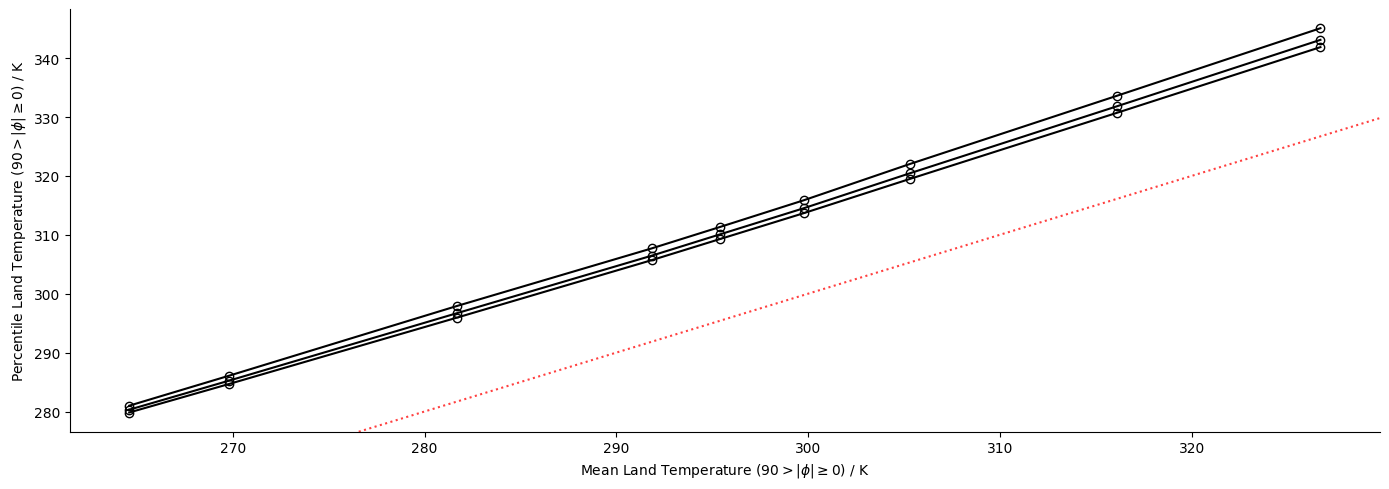

In [122]:
trend_line_on = True
save_trend_fig = False
# surf_plot = ['ocean', 'land']
surf_plot = ['land']

temp_mean_weight = {surf: np.average(temp_mean[surf], axis=1, weights=lat_weights) for surf in ['ocean', 'land']}
temp_quant_weight = {surf: np.average(temp_quant_x[surf], axis=1, weights=lat_weights) for surf in ['ocean', 'land']}

fig, ax = plt.subplots(1,len(surf_plot), figsize=(14, 5), sharex=True, sharey=True)
if len(surf_plot) == 1:
    ax = [ax]
for k, surf in enumerate(surf_plot):
    ax[k].spines[['right', 'top']].set_visible(False)
    for j in range(n_quant_plot):
        ax[k].plot(temp_mean_weight[surf], temp_quant_weight[surf][:, quant_plot_ind[j]], marker='o',
                   label='{}$^{}$ ({:.2f} K/K)'.format(quant_plot[j],'{th}',
                                                       np.average(temp_quant_grad[surf][:, j], weights=lat_weights)),
                   color='k', fillstyle='none')
        if trend_line_on:
            # Filled circle for reference simulation
            ax[k].plot(temp_mean_weight[surf][tau_ref_ind], temp_quant_weight[surf][tau_ref_ind, quant_plot_ind[j]],
                       marker='o', color='k', fillstyle='full')
            if j==n_quant_plot-1:
                label = 'Linear Increase'
            else:
                label = None
            ax[k].plot(temp_mean_weight[surf], np.average(temp_quant_grad_fit[surf][:, :, j], axis=1, weights=lat_weights),
                       linestyle=':', color='k', alpha=0.3, label=label)
    xlim = ax[k].get_xlim()
    ylim = ax[k].get_ylim()
    ax[k].plot([ax[k].get_ylim()[0], ax[k].get_xlim()[1]],
               [ax[k].get_ylim()[0], ax[k].get_xlim()[1]], 'r:', alpha=0.75, zorder=0,label='y=x')
    if k == len(surf_plot)-1:
        ax[k].set_xlim(xlim)
        ax[k].set_ylim(ylim)
    if trend_line_on:
        ax[k].legend(title='Percentile (Gradient)', frameon=False)
    if season == 'summer':
        ax[k].set_xlabel(f'Mean {surf.capitalize()} Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
        ax[k].set_ylabel(f'Percentile {surf.capitalize()} Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
    else:
        ax[k].set_xlabel(f'Mean {surf.capitalize()} Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
        ax[k].set_ylabel(f'Percentile {surf.capitalize()} Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
plt.tight_layout()
if save_fig or save_trend_fig:
    if trend_line_on:
        file_name = f"{region.lower()}_trend"
    else:
        file_name = f"{region.lower()}_no_trend"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)

## Theory for predicting next temperature based on the previous $\kappa$
This adds the theory prediction of temperature averaged above a percentile. The theory can predict the temperature at the next kappa value based on the previous optical depth value.

In [115]:
# Get MSE percentile, p_x, corresponding to MSE averaged over all days exceeding x percentile in temperature
mse_quant_px = {'ocean': np.zeros((n_exp, n_lat, n_quant_all)), 'land': np.zeros((n_exp, n_lat, n_quant_all))}
for surf in mse_quant_px.keys():
    for k in range(n_lat):
        mse_quant_px[surf][:, k] = get_px([ds_all[surf][i].sel(lat=ds_all[surf][i].lat[k]) for i in range(n_exp)],
                                          mse_quant_x[surf][:, k], quant_all)
p_x = np.round(mse_quant_px['land']).astype(int)
if p_x.max()>99:
    warnings.warn(f'Changing {(p_x>99).sum()} values to 99 from over 100')
    p_x = np.clip(p_x, -1, 99)

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_35389/2775837284.py:9: UserWarning: Changing 28 values to 99 from over 100
  warnings.warn(f'Changing {(p_x>99).sum()} values to 99 from over 100')


In [116]:
# get theory predictions for all quantiles
delta_temp_quant = {surf: np.diff(temp_quant_x[surf], axis=0) for surf in ['ocean', 'land']}
delta_temp_mean =  {surf: np.diff(temp_mean[surf], axis=0) for surf in ['ocean', 'land']}
delta_temp_quant_theory = {'full': np.zeros((n_exp-1, n_lat, n_quant_all)),
                           'const_rh': np.zeros((n_exp-1, n_lat, n_quant_all))}

# theory1 adds theoretical delta_temp to simulated value of previous kappa
temp_quant_theory = {method: temp_quant_x['land'].copy() for method in delta_temp_quant_theory.keys()}
# theory2 adds the same theoretical delta_temp to theory prediction of previous kappa so errors accumulate
temp_quant_theory2 = {method: temp_quant_x['land'].copy() for method in delta_temp_quant_theory.keys()}
for method in delta_temp_quant_theory:
    for k in range(n_lat):
        delta_temp_quant_theory[method][:, k] = \
            get_delta_temp_quant_theory(temp_mean['land'][:, k], sphum_mean['land'][:, k], temp_quant_x['land'][:, k],
                                        temp_quant_p['ocean'][:, k], sphum_quant_x['land'][:, k], sphum_quant_p['ocean'][:, k],
                                        quant_all, p_x[:, k], p_surface, True if method=='const_rh' else False)
    temp_quant_theory[method][1:] = temp_quant_x['land'][:-1] + delta_temp_quant_theory[method]
    for i in range(n_exp-1):
        temp_quant_theory2[method][1+i] = temp_quant_theory2[method][i] + delta_temp_quant_theory[method][i]

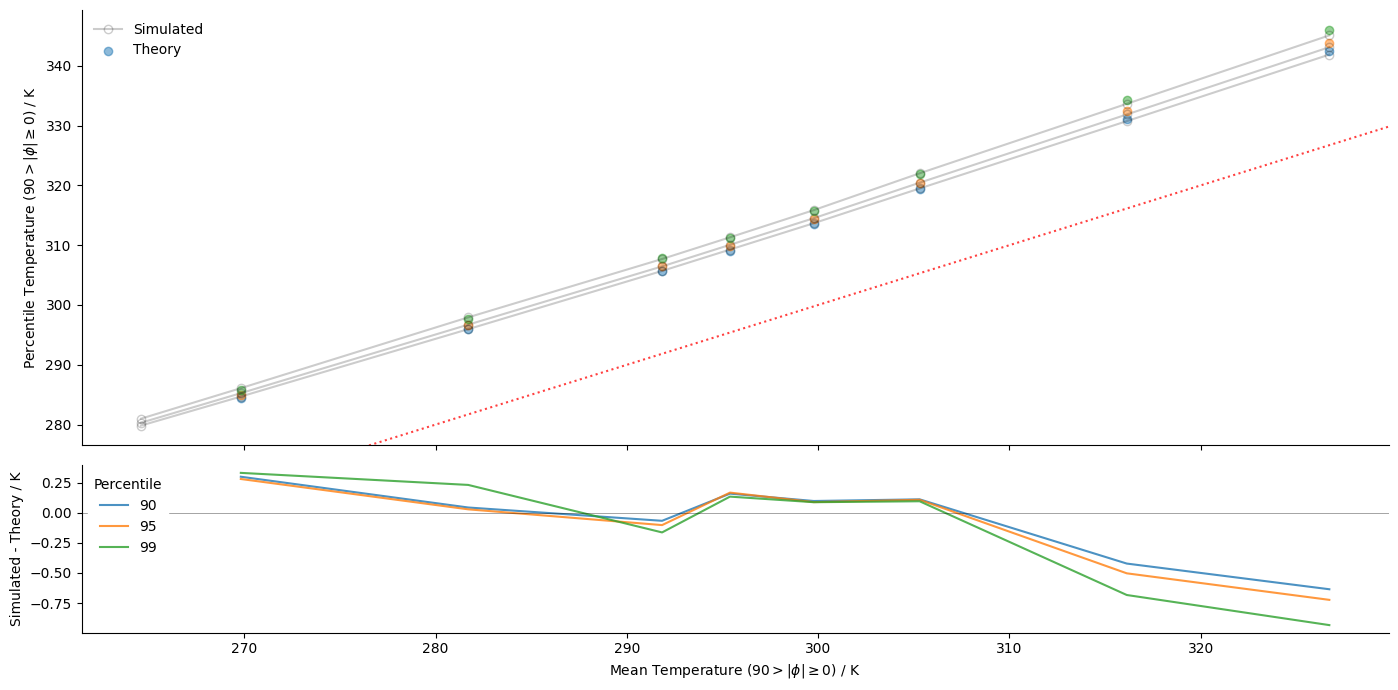

In [123]:
save_trend_theory_fig = False
method = 'full'     # which method to plot - 'full' or 'const_rh'
# method = 'const_rh'
fig, ax = plt.subplots(2,1, figsize=(14, 7), sharex=True, gridspec_kw={'height_ratios': [2.6, 1]})
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
for j in range(n_quant_plot):
    ax[0].plot(temp_mean_weight['land'], temp_quant_weight['land'][:, quant_plot_ind[j]],
               marker='o', color='k', fillstyle='none', alpha=0.2)
    ax[0].scatter(temp_mean_weight['land'][1:], np.average(temp_quant_theory[method][:, :, quant_plot_ind[j]],
                                                           axis=1, weights=lat_weights)[1:], alpha=0.5)
    ax[1].plot(temp_mean_weight['land'][1:], temp_quant_weight['land'][1:, quant_plot_ind[j]]-
               np.average(temp_quant_theory[method][:, :, quant_plot_ind[j]], axis=1, weights=lat_weights)[1:],
               label=quant_plot[j], alpha=0.8)
ax[0].legend(['Simulated', 'Theory'], loc='upper left', frameon=False)
ax[1].legend(title='Percentile', loc='upper left', frameon=True, framealpha=1, edgecolor='white')
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[1].hlines(0, xlim[0], xlim[1], color='k', alpha=0.5, linewidth=0.5)
ax[0].plot([ax[0].get_ylim()[0], ax[0].get_xlim()[1]], [ax[0].get_ylim()[0], ax[0].get_xlim()[1]], 'r:', alpha=0.75, zorder=0,label='y=x')
ax[0].set_ylim(ylim)
ax[0].set_xlim(xlim)
if season == 'summer':
    ax[-1].set_xlabel(f'Mean Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
    ax[0].set_ylabel(f'Percentile Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
else:
    ax[-1].set_xlabel(f'Mean Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
    ax[0].set_ylabel(f'Percentile Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
ax[1].set_ylabel('Simulated - Theory / K')
plt.tight_layout()
if save_fig or save_trend_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/{region.lower()}_theory_{method}",dpi=high_dpi if publish_fig else low_dpi)

The plot below is like that above, but is showing the predicted amplification factor compared to the actual one. The denominator in $\delta T^x_L/\delta \overline{T}$ is the change in the mean temperature as the theory can predict this too i.e. it corresponds to $x=0$.

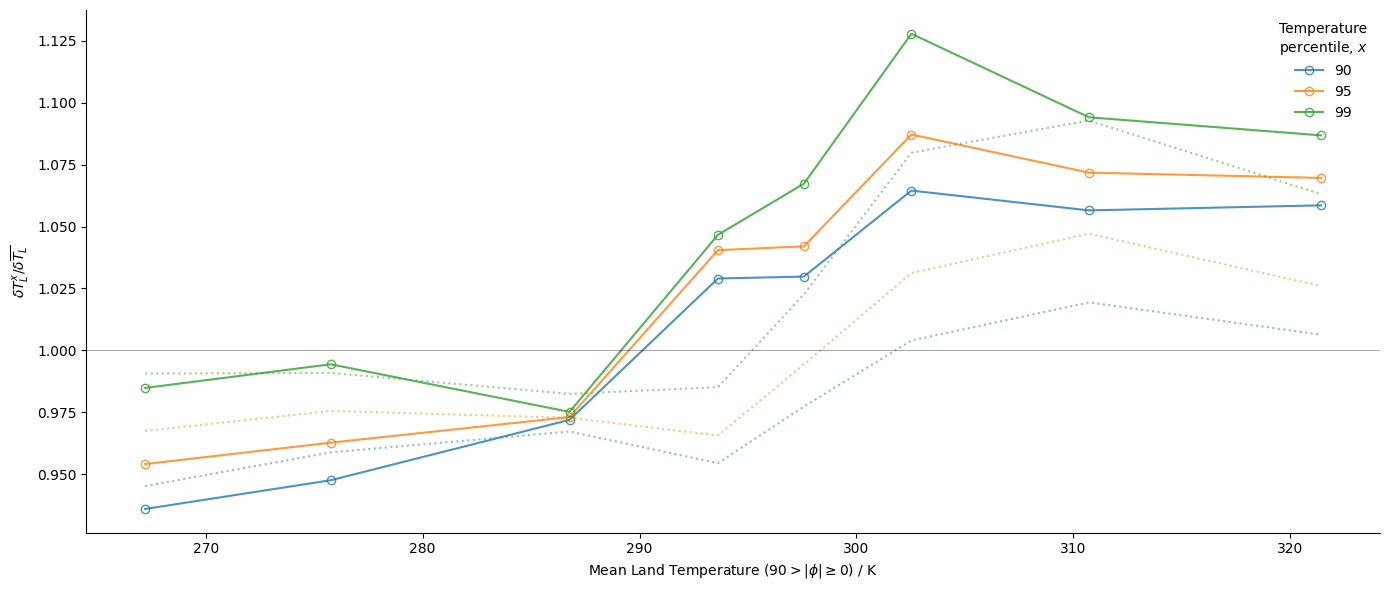

In [124]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

save_amp_factor_fig=False
fig, ax = plt.subplots(1,1, figsize=(14, 6))
ax.spines[['right', 'top']].set_visible(False)
for j in range(n_quant_plot):
    # for difference between simulations, make x-axis the average between the two mean temperatures
    ax.plot(moving_average(temp_mean_weight['land'], 2),
            np.average(delta_temp_quant['land'][:, :, quant_plot_ind[j]]/delta_temp_mean['land'], axis=1, weights=lat_weights),
            color=default_colors[j], alpha=0.8, marker='o', fillstyle='none', label=quant_plot[j])
    ax.plot(moving_average(temp_mean_weight['land'], 2),
            np.average(delta_temp_quant_theory[method][:, :, quant_plot_ind[j]]/delta_temp_quant_theory[method][:, :, 0],
                       axis=1, weights=lat_weights), color=default_colors[j], linestyle=':', alpha=0.5)
ax.legend(title='Temperature\npercentile, $x$', frameon=False)
xlim = ax.get_xlim()
ax.hlines(1, xlim[0], xlim[1], color='k', alpha=0.5, linewidth=0.5)
ax.set_xlim(xlim)
if season == 'summer':
    ax.set_xlabel(f'Mean Summer Land Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
else:
    ax.set_xlabel(f'Mean Land Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
ax.set_ylabel('$\delta T^x_L/\delta \overline{T_L}$')
plt.tight_layout()
if save_fig or save_amp_factor_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/{region.lower()}_amplification_factor_{method}",
                dpi=high_dpi if publish_fig else low_dpi)

## Figure 2 of Byrne 2021 - combining $\kappa$
The gradients in the above plot indicate the scaling factors shown in the bottom plot of Byrne 2021 figure 2, but combine all $\kappa$ values indicated by `scaling_factor_kappa_use`. So I plot the gradients versus percentile, $x$, here to replicate the figure.

I include the option for two different quantiles. In Byrne 2021, it is the temperatures averaged over a given percentile - I refer to this as `temp_quant_x`. The other option is using the actual percentile, given here as `temp_quant_p`.

For the mean below, I don't use area weighting, whereas I do above, hence the difference. I don't use it below so that `temp_quant_x` plot always shows a scaling factor of $1$ for $x=0$.

To see if the scaling factor is different for warmer vs colder climates, I compute the gradients using a subset of $\kappa$ values. For colder climates, I use $\kappa=0.2, 0.3, 0.6, 1$ and force the line through $\kappa=1$. For warmer climates, I use $\kappa=1, 1.2, 1.5, 2, 3.5, 6$ and force the line through $\kappa=1.5$. It may make more sense to force the line through the same $\kappa$ values for both though. The solid line includes all $\kappa$ and is forced through $\kappa = 1$.

In [119]:
sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1)[0], np.where(tau_lw>=1)[0]]
sf_tau_ref = [1, 1, 1]
n_sf = len(sf_tau_use)
# all temperatures averaged above x=0 - same as temp_av except for no area averaging
scaling_factor = {'ocean': np.zeros((n_sf, n_lat, n_quant_all)), 'land': np.zeros((n_sf, n_lat, n_quant_all))}
scaling_factor_theory = {method: np.zeros((n_lat, n_quant_all)) for method in delta_temp_quant_theory.keys()}

for i in range(n_sf):
    sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]
    for j in range(n_quant_all):
        # The theory predicts mean change.
        # This means x=0 will correspond to y=1 in all plots below.
        for k in range(n_lat):
            for surf in ['ocean', 'land']:
                scaling_factor[surf][i, k, j] = get_gradient(temp_quant_x[surf][sf_tau_use[i], k, j],
                                                             temp_mean[surf][sf_tau_use[i], k], sf_tau_ref_ind)[0]
            if i == 0:
                for method in scaling_factor_theory.keys():
                    # Use theory2 version for scaling factor as errors compounded - makes most sense to me
                    scaling_factor_theory[method][k, j] = \
                        get_gradient(temp_quant_theory2[method][sf_tau_use[i], k, j],
                                     temp_quant_theory2[method][sf_tau_use[i], k, 0], sf_tau_ref_ind)[0]

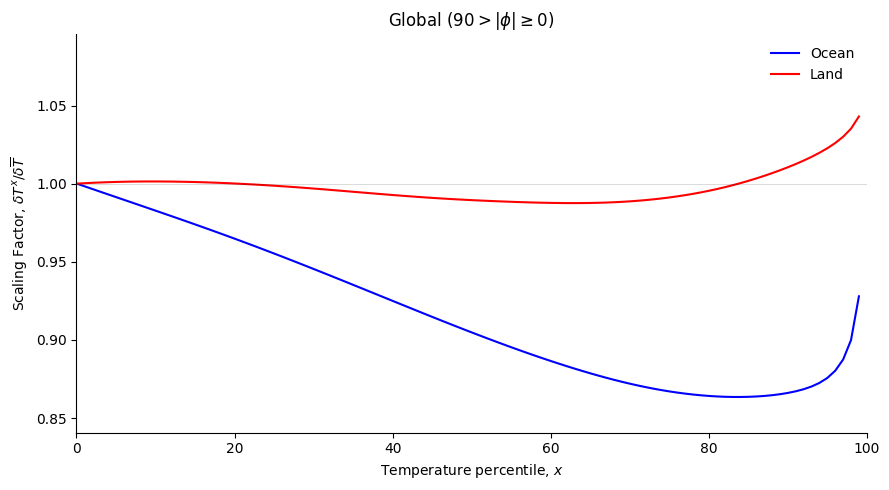

In [125]:
save_sf_fig = False
# if publishing figure, use high dpi
publish_fig = True
surf_colors = {'ocean': 'b', 'land': 'r'}
fig, ax = plt.subplots(1,1, figsize=(9, 5))
ax.spines[['right', 'top']].set_visible(False)
for surf in ['ocean', 'land']:
    ax.plot(quant_all, np.average(scaling_factor[surf][0], axis=0, weights=lat_weights), color=surf_colors[surf], label=surf.capitalize())
    ax.plot(quant_all, np.average(scaling_factor[surf][1], axis=0, weights=lat_weights), color=surf_colors[surf], linestyle=':')
    ax.plot(quant_all, np.average(scaling_factor[surf][2], axis=0, weights=lat_weights), color=surf_colors[surf], linestyle='--')
ax.hlines(1, 0, 100, linewidth=0.5, alpha=0.2, color='k')
ax.lines[1].set_label(f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$')
ax.lines[2].set_label(f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$')
# # Remove some of the lines but keep ylims the same for presentation plots
# ax.lines.pop(1)
# ax.lines.pop(1)
# ax.lines.pop(2)
# ax.lines.pop(2)
ax.legend(frameon=False)
ax.set_xlim(0,100)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax.set_title(f'{region.capitalize()} (${lat_max}>|\phi| \geq {lat_min}$)')
plt.tight_layout()
if save_fig or save_sf_fig:
    file_name = f"scaling_factor_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)

The solid red line below is the same as that above. The black lines show the theoretical prediction for the red line, combining all kappa values.

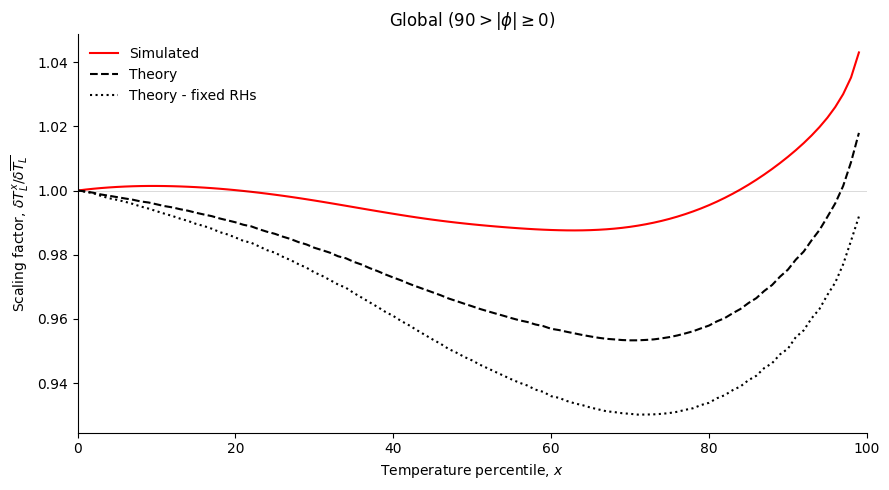

In [121]:
save_sf_theory_fig = False
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(9, 5))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(quant_all, np.average(scaling_factor['land'][0], axis=0, weights=lat_weights), color=surf_colors['land'], label='Simulated')
ax.plot(quant_all, np.average(scaling_factor_theory['full'], axis=0, weights=lat_weights),
        color='k', linestyle='--', label=f'Theory')
ax.plot(quant_all, np.average(scaling_factor_theory['const_rh'], axis=0, weights=lat_weights),
        color='k', linestyle=':', label= f'Theory - fixed RHs')
ax.hlines(1, 0, 100, linewidth=0.5, alpha=0.2, color='k')
# # Remove some of the lines but keep ylims the same for presentation plots
# ax.lines.pop(2)
# ax.lines.pop(1)
ax.legend(frameon=False)
ax.set_xlim(0,100)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Scaling factor, $\delta T^x_L/\delta \overline{T_L}$')
ax.set_title(f'{region.capitalize()} (${lat_max}>|\phi| \geq {lat_min}$)')
plt.tight_layout()
if save_fig or save_sf_theory_fig:
    file_name = f"scaling_factor_theory_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)